### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240223

Yoshida PBMC dataset (subsetted to contain only healthy donors) and healthy human heart leucocytes (from Human cell atlas) were combined to generate a reference for seed labelling

### Import required modules

In [8]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [9]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.9.3
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits  

In [10]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [11]:
torch.set_float32_matmul_precision('high')

In [12]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [13]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [14]:
reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merged_healthy_reference_PBMC_Heart_ac240222.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 214552 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

In [15]:
X_is_raw(reference)

True

In [16]:
reference.obs['seed_labels'].value_counts()

seed_labels
CD4+T           53575
CD8+T           42060
Monocytes       35482
B_cells         27327
NK              25499
Macrophages     14519
Treg             6434
DC               2259
NKT              1683
Mast_cells       1543
Hematopoetic     1534
pDC               706
Platelets         626
Doublets          623
Plasma_cells      352
ILC               199
Neutrophils       121
Baso_Eosino        10
Name: count, dtype: int64

In [17]:
reference.obs['seed_labels'].cat.categories

Index(['B_cells', 'Baso_Eosino', 'CD4+T', 'CD8+T', 'DC', 'Doublets',
       'Hematopoetic', 'ILC', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK',
       'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'],
      dtype='object')

### Subset populations of interest

In [18]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells
reference.obs['seed_labels'].value_counts()

seed_labels
CD4+T           53575
CD8+T           42060
Monocytes       35482
B_cells         27327
NK              25499
Macrophages     14519
Treg             6434
DC               2259
NKT              1683
Mast_cells       1543
Hematopoetic     1534
pDC               706
Platelets         626
Doublets          623
Plasma_cells      352
ILC               199
Neutrophils       121
Baso_Eosino        10
Name: count, dtype: int64

In [19]:
sc.pp.filter_cells(reference, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference, min_counts = 100)

filtered out 1 cells that have less than 200 genes expressed


### Read in other query

In [20]:
query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_demux_QCed_ac240221.raw.h5ad')
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm'

In [21]:
X_is_raw(query)

True

In [22]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [23]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [24]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 222398 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query'

In [25]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
CD4+T           53575
CD8+T           42060
Monocytes       35482
B_cells         27327
NK              25499
Macrophages     14519
Unknown          7847
Treg             6434
DC               2259
NKT              1683
Mast_cells       1543
Hematopoetic     1533
pDC               706
Platelets         626
Doublets          623
Plasma_cells      352
ILC               199
Neutrophils       121
Baso_Eosino        10
Name: count, dtype: int64

In [26]:
adata.obs['batch'].value_counts()

batch
reference    214551
query          7847
Name: count, dtype: int64

### Select HVGs

In [27]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
NP18                 9799
D6                   9362
NP13                 8945
D7                   8461
AN13                 8244
NP23                 8038
NP24                 7376
AN12                 7219
AN7                  7105
NP19                 7050
NP28                 6894
NP17                 6377
NP39                 6115
AN2                  5973
NP44                 5906
NP36                 5891
D11                  5635
NP22                 5535
NP27                 5300
NP31                 5029
NP21                 4833
NP37                 4654
AN6                  4296
AN9                  4150
AN5                  3943
NP30                 3916
NP41                 3898
NP32                 3778
NP15                 3700
NP26                 3539
NP20                 3374
NP38                 3218
H2                   2655
AN14                 2260
D3                   2119
D2                   2034
H3                   1965
NP16                 1851
AN11  

In [28]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 222398 × 7000
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query',

### Transfer of annotation with scANVI

In [29]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [30]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [31]:
scvi_model.train(15, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 15/15: 100%|██████████| 15/15 [02:29<00:00,  9.52s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.14e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [02:29<00:00, 10.00s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.14e+3]


### Evaluate model performance a la _Sevensson_

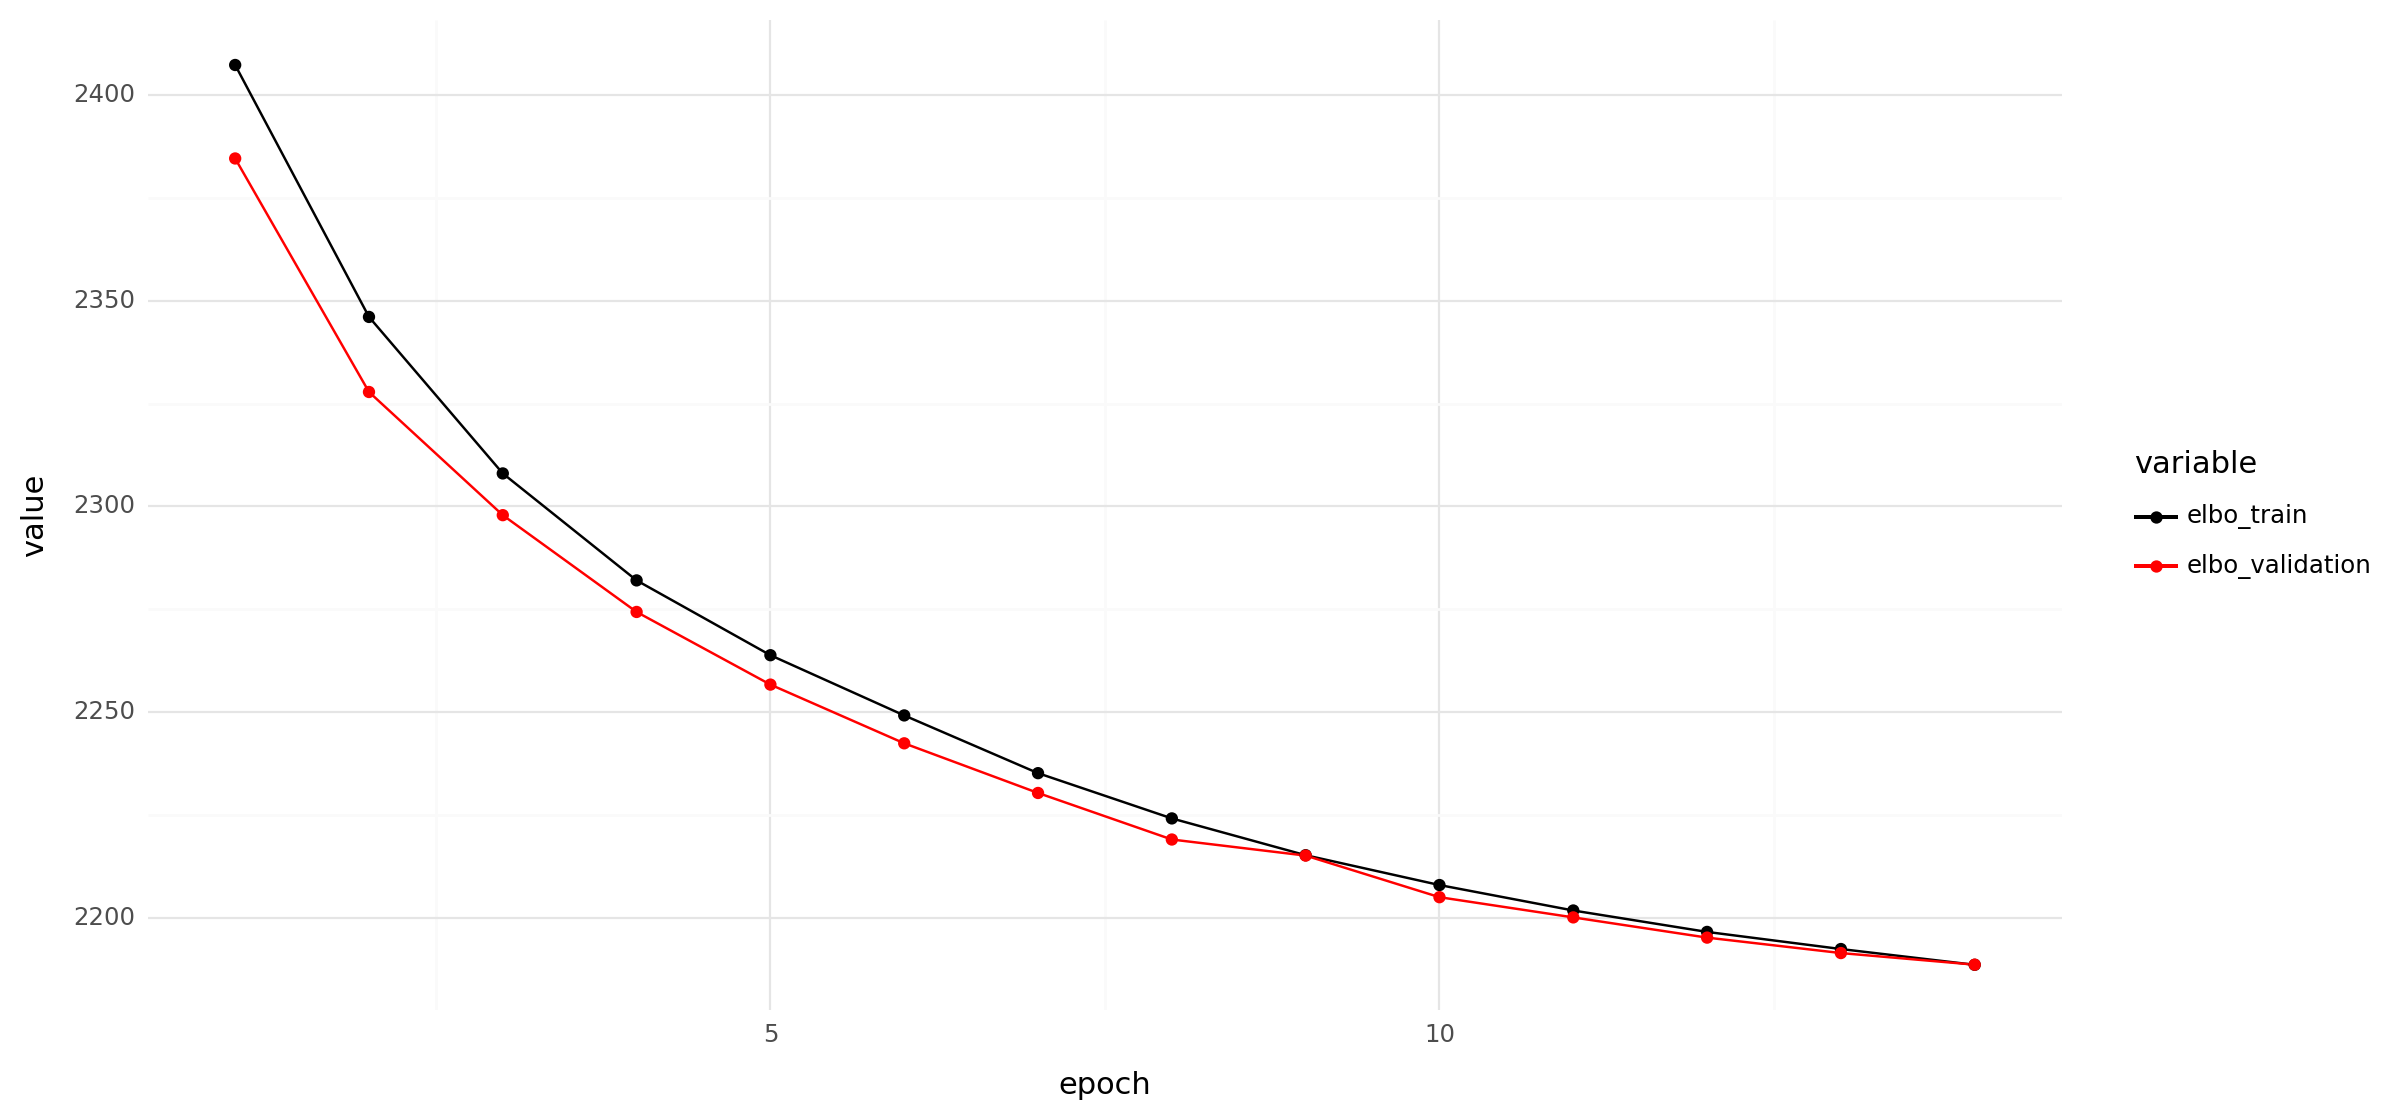

In [32]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scVI_15epochs.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [33]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [34]:
scanvi_model.train(14, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 14 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 14/14: 100%|██████████| 14/14 [06:10<00:00, 23.88s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.13e+3]

`Trainer.fit` stopped: `max_epochs=14` reached.


Epoch 14/14: 100%|██████████| 14/14 [06:10<00:00, 26.49s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.13e+3]


### Evaluate model performance a la Svensson

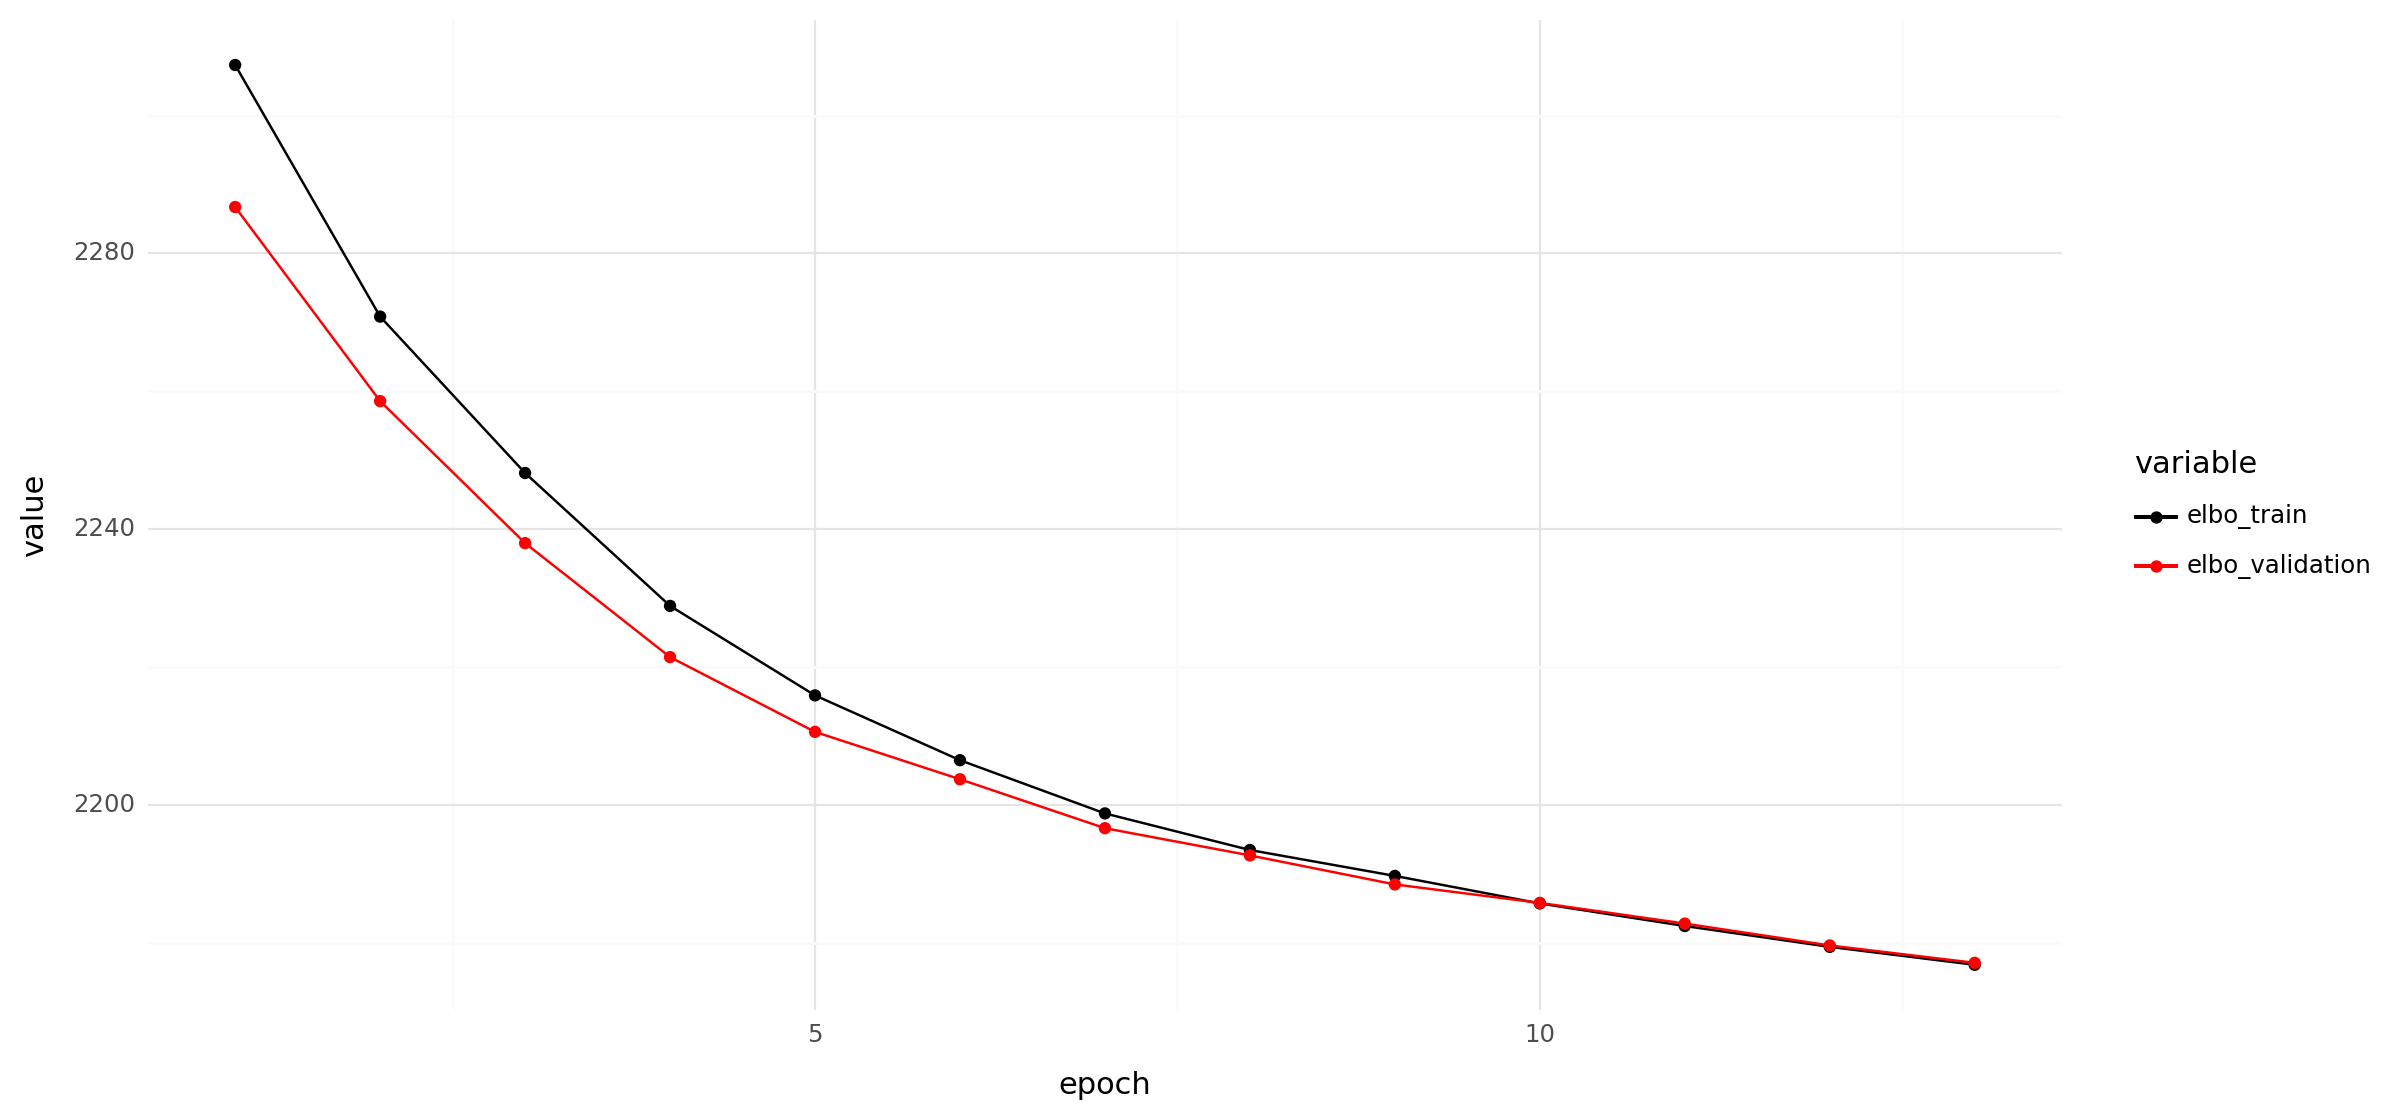

In [35]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scANVI_14epochs.png', dpi = 300)

print(p_)

In [36]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [37]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [48]:
adata.obs

,COVID_status,annotation_broad,annotation_detailed,n_counts,n_genes,age_group,donor,sample,cell_source,cell_states,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-Yoshida-reference,Healthy,Monocyte,Monocyte CD14,5493.0,1767,Adult,AN5,AN5,Yoshida,Classical monocyte,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,7,10,Monocytes
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-Yoshida-reference,Healthy,T CD4+,T CD4 helper,4866.0,1575,Adult,AN5,AN5,Yoshida,T CD4 helper,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,7,2,CD4+T
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-Yoshida-reference,Healthy,T CD4+,T CD4 helper,3176.0,1255,Adult,AN3,AN3,Yoshida,T CD4 helper,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,6,2,CD4+T
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-Yoshida-reference,Healthy,T CD8+,T CD8 naive,4743.0,1476,Adult,AN5,AN5,Yoshida,T CD8 naive,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,7,3,CD8+T
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-Yoshida-reference,Healthy,T CD4+,T CD4 naive,1902.0,954,Adult,AN5,AN5,Yoshida,T CD4 naive,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,7,2,CD4+T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,NaN,NaN,NaN,18844.0,4219,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query,54,18,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,NaN,NaN,NaN,11805.0,3321,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,NaN,NaN,NaN,3733.0,1849,NaN,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,NaN,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,NaN,NaN,NaN,6388.0,2559,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18,Macrophages


- Visualise corrected dataset

In [38]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:12)


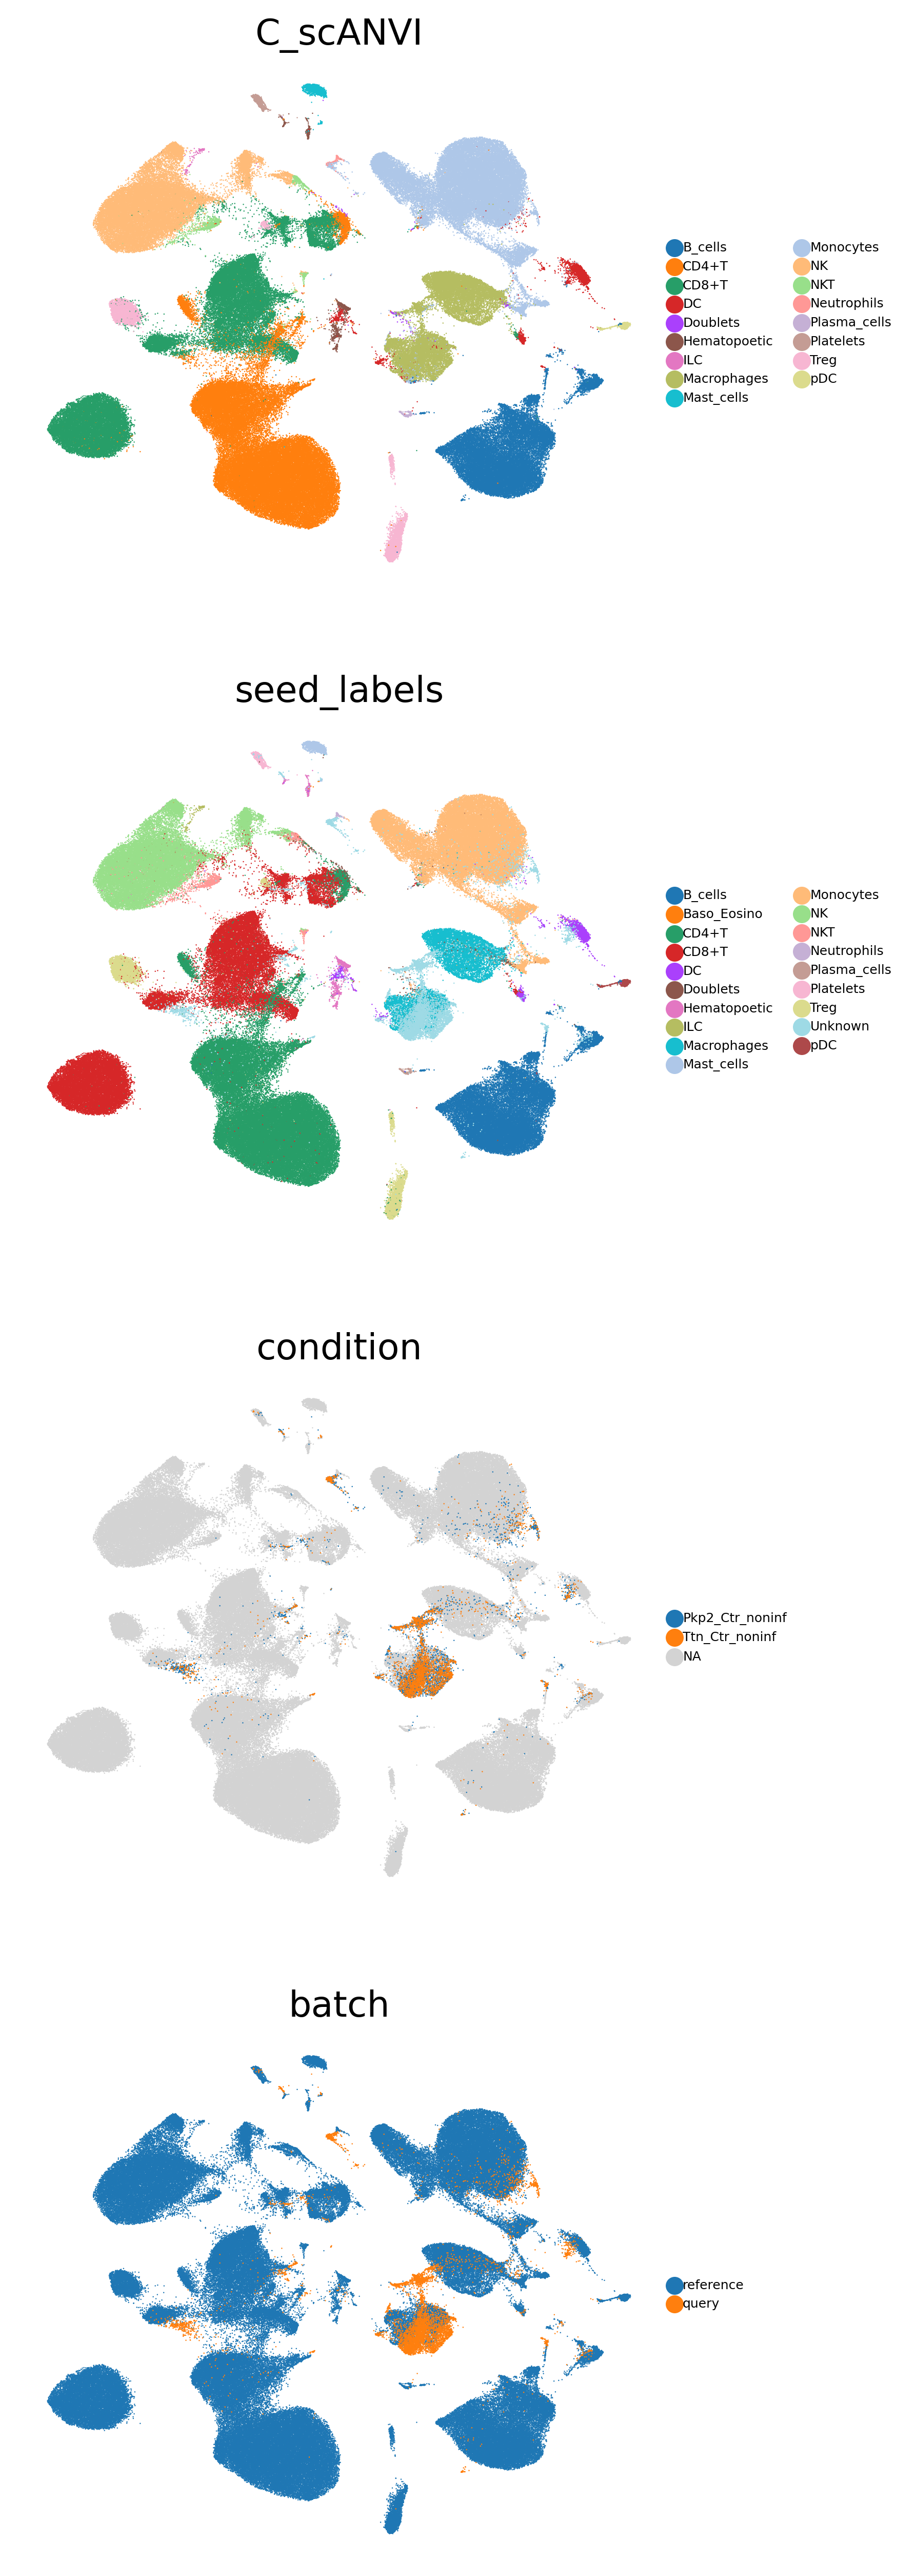

In [39]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch'], size = 1, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [40]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 222398 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_

In [41]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 7847 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_

### Add new gene symbols

In [42]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts

### Revert gene symbols

In [43]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [44]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
Macrophages     4648
Monocytes       1338
DC               453
CD8+T            418
B_cells          324
CD4+T            284
Neutrophils      130
Doublets          71
Platelets         44
NKT               40
NK                38
Hematopoetic      31
Mast_cells        13
pDC               12
Treg               2
Plasma_cells       1
Name: count, dtype: int64

In [45]:
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts

In [46]:
query_export.obs

,COVID_status,annotation_broad,annotation_detailed,n_counts,n_genes,age_group,donor,sample,cell_source,cell_states,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,NaN,NaN,NaN,8562.0,2769,NaN,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,50,18,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,NaN,NaN,NaN,750.0,365,NaN,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,NaN,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,49,18,Macrophages
AAACGCTTCTCGCTCA-1-A1-query,NaN,NaN,NaN,3855.0,1599,NaN,Pkp2_Ctr_noninf_1,Pkp2_Ctr_noninf_1,AG_Gerull,NaN,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,49,18,Monocytes
AAAGGTACAGAACATA-1-A1-query,NaN,NaN,NaN,17536.0,3854,NaN,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,...,10.213276,0.027315,0.051323,0.0,-0.317631,-0.578954,query,50,18,Monocytes
AAAGTCCAGGGACACT-1-A1-query,NaN,NaN,NaN,14174.0,3788,NaN,Pkp2_Ctr_noninf_2,Pkp2_Ctr_noninf_2,AG_Gerull,NaN,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query,50,18,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,NaN,NaN,NaN,18844.0,4219,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291861,query,54,18,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,NaN,NaN,NaN,11805.0,3321,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,54,18,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,NaN,NaN,NaN,3733.0,1849,NaN,Ttn_Ctr_noninf_1,Ttn_Ctr_noninf_1,AG_Gerull,NaN,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,53,18,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,NaN,NaN,NaN,6388.0,2559,NaN,Ttn_Ctr_noninf_2,Ttn_Ctr_noninf_2,AG_Gerull,NaN,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,54,18,Macrophages


In [47]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')   